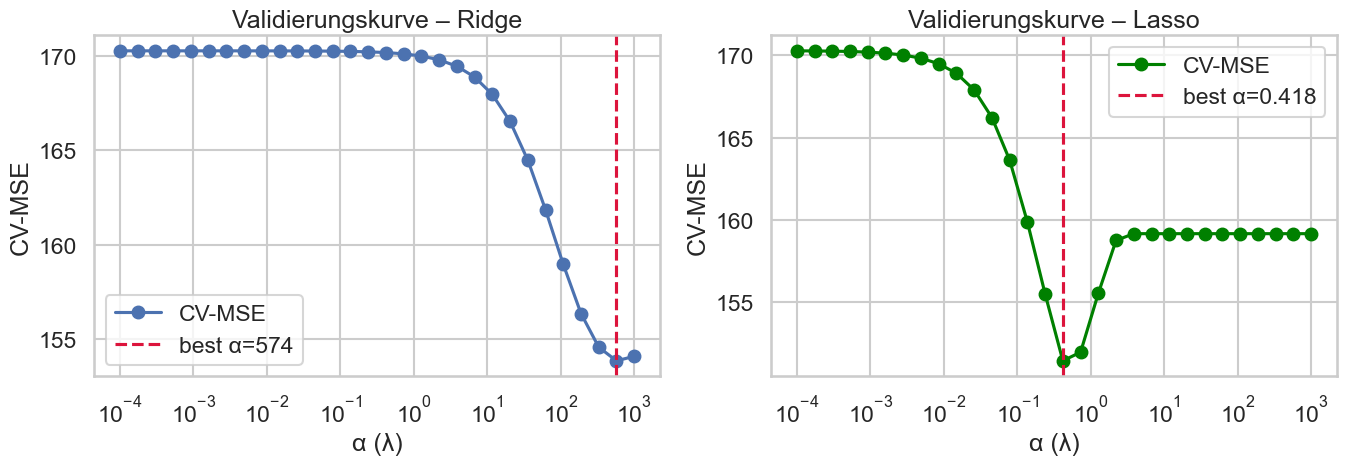

[CV] bestes Ridge-α: 573.615251   |   bestes Lasso-α: 0.417532
     RIDGE  |  Test-MSE=153.738  R^2=0.047
     LASSO  |  Test-MSE=152.258  R^2=0.056


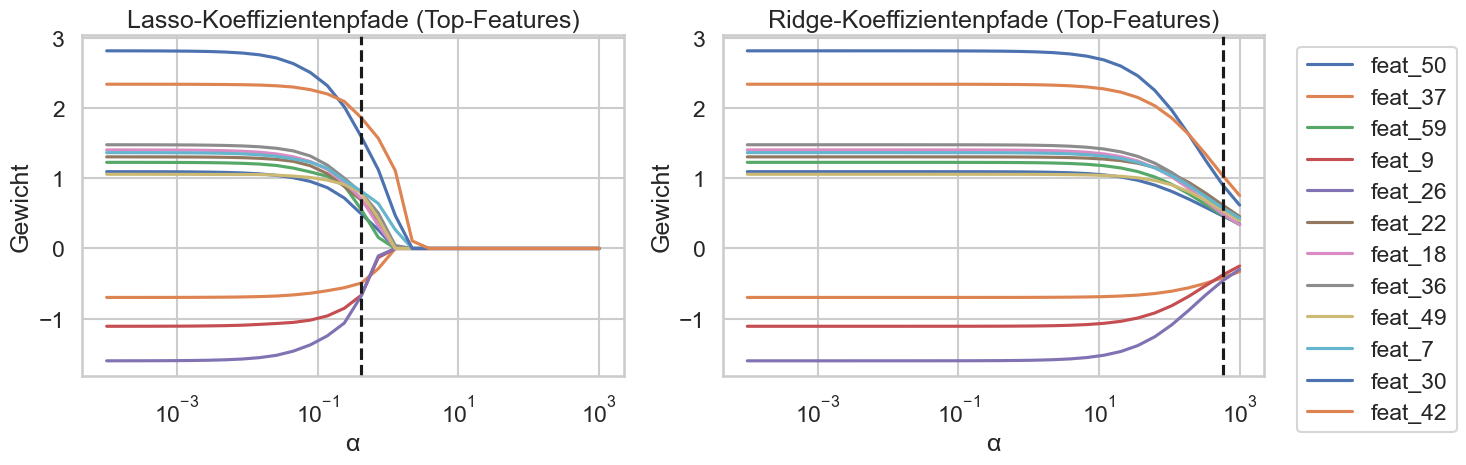

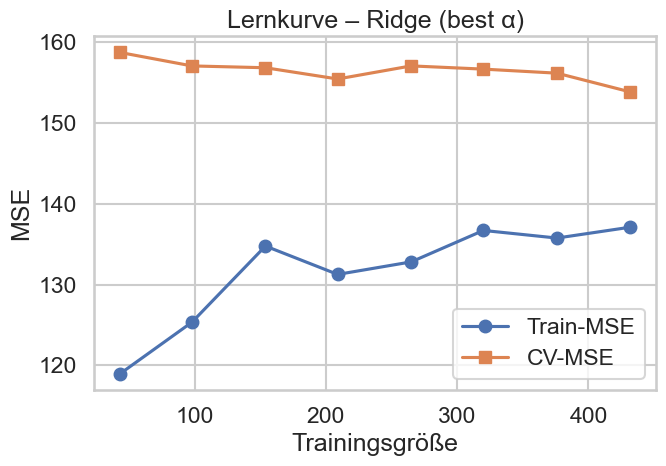


[AIC/BIC] (kleiner ist besser, absolute Skalen nur relativ interpretieren):
Modell         AIC         BIC          RSS
 Ridge 1419.370980 1422.897012 27672.763671
 Lasso 1467.422101 1550.438980 27406.511318
   OLS 1556.464804 1751.235172 30464.845681


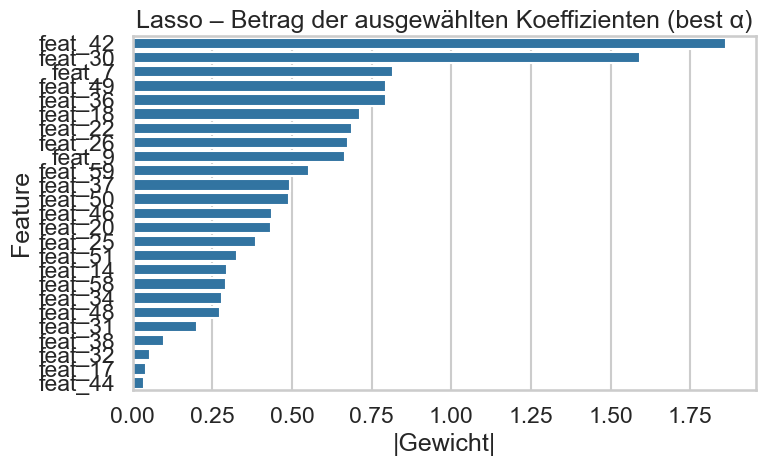


Fertig: Wir haben CV-gestützte Modellauswahl, Lernkurven, Koeffizientenpfade und AIC/BIC praktisch demonstriert.


In [1]:
"""
Vorlesung 7 – Modellauswahl & Regularisierung (ein einziges, kommentiertes Snippet)

Inhalte:
1) Synthetische Regressionsdaten mit Korrelation + Rauschen (teilweise irrelevante Features)
2) Ridge vs. Lasso: k-fache Cross-Validation (Validierungskurven) für Alpha (λ)
3) Auswahl des besten Alpha, Fit und Test-Messung (MSE, R^2)
4) Lasso- und Ridge-Koeffizientenpfade (wie schrumpfen Gewichte?)
5) Lernkurve (Train/CV-Fehler vs. Trainingsgröße)
6) AIC/BIC-Vergleich (mit effektiven Freiheitsgraden für Ridge und #Nichtnull für Lasso)

Benötigt: numpy, pandas, seaborn, matplotlib, scikit-learn
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold, validation_curve, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style="whitegrid", context="talk")
rng = np.random.default_rng(7)

# ------------------------------------------------------------
# 0) Daten erzeugen: korrelierte Features, teilw. irrelevant
# ------------------------------------------------------------
X, y, coef_true = make_regression(
    n_samples=900, n_features=60, n_informative=12,
    effective_rank=20,  # erzeugt Korrelation/Multikollinearität
    noise=12.0, bias=3.0, coef=True, random_state=7
)
feature_names = [f"feat_{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names); df["y"] = y

# Split: 60% Train, 20% Val, 20% Test (Val nutzen wir implizit in CV)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val,  y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
# (Wir verwenden gleich k-fache CV auf X_train; X_val bleibt ungenutzt, nur der Form halber.)

# ------------------------------------------------------------
# 1) Validierungskurven: Ridge und Lasso (5-fach CV)
# ------------------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=123)
alphas = np.logspace(-4, 3, 30)

pipe_ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
train_ridge, val_ridge = validation_curve(
    pipe_ridge, X_train, y_train,
    param_name="ridge__alpha", param_range=alphas,
    scoring="neg_mean_squared_error", cv=cv, n_jobs=None
)
pipe_lasso = Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(max_iter=5000))])
train_lasso, val_lasso = validation_curve(
    pipe_lasso, X_train, y_train,
    param_name="lasso__alpha", param_range=alphas,
    scoring="neg_mean_squared_error", cv=cv, n_jobs=None
)

mean_val_ridge = -val_ridge.mean(axis=1)
mean_val_lasso = -val_lasso.mean(axis=1)
best_alpha_ridge = alphas[np.argmin(mean_val_ridge)]
best_alpha_lasso = alphas[np.argmin(mean_val_lasso)]

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].semilogx(alphas, mean_val_ridge, marker="o", label="CV-MSE")
ax[0].axvline(best_alpha_ridge, color="crimson", linestyle="--", label=f"best α={best_alpha_ridge:.3g}")
ax[0].set_title("Validierungskurve – Ridge"); ax[0].set_xlabel("α (λ)"); ax[0].set_ylabel("CV-MSE"); ax[0].legend()

ax[1].semilogx(alphas, mean_val_lasso, marker="o", color="green", label="CV-MSE")
ax[1].axvline(best_alpha_lasso, color="crimson", linestyle="--", label=f"best α={best_alpha_lasso:.3g}")
ax[1].set_title("Validierungskurve – Lasso"); ax[1].set_xlabel("α (λ)"); ax[1].set_ylabel("CV-MSE"); ax[1].legend()
plt.tight_layout(); plt.show()

print(f"[CV] bestes Ridge-α: {best_alpha_ridge:.6f}   |   bestes Lasso-α: {best_alpha_lasso:.6f}")

# ------------------------------------------------------------
# 2) Endmodelle fitten (auf Train) und auf Test evaluieren
# ------------------------------------------------------------
ridge_final = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=best_alpha_ridge))]).fit(X_train, y_train)
lasso_final = Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=best_alpha_lasso, max_iter=5000))]).fit(X_train, y_train)

def eval_model(name, model):
    y_hat = model.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    print(f"{name:>10s}  |  Test-MSE={mse:.3f}  R^2={r2:.3f}")
    return y_hat, mse, r2

yhat_ridge, mse_ridge, r2_ridge = eval_model("RIDGE", ridge_final)
yhat_lasso, mse_lasso, r2_lasso = eval_model("LASSO", lasso_final)

# ------------------------------------------------------------
# 3) Koeffizientenpfade (wie schrumpfen Gewichte mit α?)
#    Wir fitten auf STANDARDISIERTEN Train-Features für Pfade.
# ------------------------------------------------------------
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)

lasso_coefs = []
ridge_coefs = []
for a in alphas:
    l = Lasso(alpha=a, max_iter=5000).fit(Xtr_s, y_train)
    r = Ridge(alpha=a).fit(Xtr_s, y_train)
    lasso_coefs.append(l.coef_)
    ridge_coefs.append(r.coef_)
lasso_coefs = np.array(lasso_coefs)  # shape (len(alphas), d)
ridge_coefs = np.array(ridge_coefs)

# Zeige Pfade der 12 "wichtigsten" (nach |Lasso-Koeff. bei best α|)
lasso_best = Lasso(alpha=best_alpha_lasso, max_iter=5000).fit(Xtr_s, y_train)
top_idx = np.argsort(np.abs(lasso_best.coef_))[-12:]

fig, ax = plt.subplots(1,2, figsize=(15,5))
for j in top_idx:
    ax[0].semilogx(alphas, lasso_coefs[:, j], label=feature_names[j])
ax[0].axvline(best_alpha_lasso, color="k", linestyle="--")
ax[0].set_title("Lasso-Koeffizientenpfade (Top-Features)"); ax[0].set_xlabel("α"); ax[0].set_ylabel("Gewicht")

for j in top_idx:
    ax[1].semilogx(alphas, ridge_coefs[:, j], label=feature_names[j])
ax[1].axvline(best_alpha_ridge, color="k", linestyle="--")
ax[1].set_title("Ridge-Koeffizientenpfade (Top-Features)"); ax[1].set_xlabel("α"); ax[1].set_ylabel("Gewicht")
ax[1].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 4) Lernkurve (Train/CV-Fehler vs. Trainingsgröße) für Ridge
# ------------------------------------------------------------
ridge_best_pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=best_alpha_ridge))])
train_sizes, tr_scores, cv_scores = learning_curve(
    ridge_best_pipe, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=cv, scoring="neg_mean_squared_error", shuffle=True, random_state=123
)
tr_mse = -tr_scores.mean(axis=1); cv_mse = -cv_scores.mean(axis=1)
plt.figure(figsize=(7,5))
plt.plot(train_sizes, tr_mse, marker="o", label="Train-MSE")
plt.plot(train_sizes, cv_mse, marker="s", label="CV-MSE")
plt.xlabel("Trainingsgröße"); plt.ylabel("MSE"); plt.title("Lernkurve – Ridge (best α)")
plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 5) AIC/BIC (approx.) – OLS, Ridge (df via Tr(S)), Lasso (#Nichtnull)
# ------------------------------------------------------------
# Hilfsfunktionen
def aic_bic_from_residuals(y_true, y_pred, k):
    n = len(y_true)
    rss = np.sum((y_true - y_pred)**2)
    sigma2 = rss / n
    # log-Likelihood unter Normalverteilung (Konstanten beeinflussen nur absolute Werte, nicht Vergleiche)
    logL = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    AIC = 2 * k - 2 * logL
    BIC = k * np.log(n) - 2 * logL
    return AIC, BIC, rss

# Effektive df für Ridge: df = tr( S ) mit S = X (X^T X + n α I)^{-1} X^T
def ridge_df(X_std, alpha):
    n, p = X_std.shape
    A = X_std.T @ X_std + n * alpha * np.eye(p)
    H = X_std @ np.linalg.solve(A, X_std.T)
    return np.trace(H)

# OLS (ohne Regularisierung) – nur zum Vergleich:
ols_pipe = Pipeline([("scaler", StandardScaler()), ("ols", LinearRegression())]).fit(X_train, y_train)
yhat_ols_test = ols_pipe.predict(X_test)

# Ridge AIC/BIC (df ~ tr(S) + 1 für Intercept)
df_ridge = ridge_df(StandardScaler().fit(X_train).transform(X_train), best_alpha_ridge) + 1
AIC_ridge, BIC_ridge, RSS_ridge = aic_bic_from_residuals(y_test, yhat_ridge, k=df_ridge)

# Lasso AIC/BIC (k = #Nichtnull + 1 Intercept)
lasso_scaled = StandardScaler().fit(X_train).transform(X_train)
lasso_fit = Lasso(alpha=best_alpha_lasso, max_iter=5000).fit(lasso_scaled, y_train)
k_lasso = int(np.sum(np.abs(lasso_fit.coef_) > 1e-10)) + 1
AIC_lasso, BIC_lasso, RSS_lasso = aic_bic_from_residuals(y_test, yhat_lasso, k=k_lasso)

# OLS AIC/BIC (k = p + 1)
p = X.shape[1] + 1
AIC_ols, BIC_ols, RSS_ols = aic_bic_from_residuals(y_test, yhat_ols_test, k=p)

aic_df = pd.DataFrame({
    "Modell": ["OLS", "Ridge", "Lasso"],
    "AIC": [AIC_ols, AIC_ridge, AIC_lasso],
    "BIC": [BIC_ols, BIC_ridge, BIC_lasso],
    "RSS": [RSS_ols, RSS_ridge, RSS_lasso]
}).sort_values("AIC")
print("\n[AIC/BIC] (kleiner ist besser, absolute Skalen nur relativ interpretieren):")
print(aic_df.to_string(index=False))

# ------------------------------------------------------------
# 6) Lasso-Auswahl interpretieren (Nichtnull-Koeffizienten)
# ------------------------------------------------------------
nz = np.where(np.abs(lasso_fit.coef_) > 1e-10)[0]
imp = pd.Series(lasso_fit.coef_[nz], index=[feature_names[j] for j in nz]).sort_values(key=np.abs, ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=np.abs(imp.values), y=imp.index, orient="h", color="tab:blue")
plt.title("Lasso – Betrag der ausgewählten Koeffizienten (best α)")
plt.xlabel("|Gewicht|"); plt.ylabel("Feature")
plt.tight_layout(); plt.show()

print("\nFertig: Wir haben CV-gestützte Modellauswahl, Lernkurven, Koeffizientenpfade und AIC/BIC praktisch demonstriert.")
